In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, f1_score
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime

# Data Loading and Preprocessing

In [2]:
df=pd.read_csv("dataset/train_set_rec.csv")

In [3]:
df

,Timestamp,KPI_Value,Status,KPI_Name
0,2017-04-30 16:00:00,1.901639,0,Stamping Press Efficiency
1,2017-04-30 16:01:00,1.786885,0,Stamping Press Efficiency
2,2017-04-30 16:02:00,2.000000,0,Stamping Press Efficiency
3,2017-04-30 16:03:00,1.885246,0,Stamping Press Efficiency
4,2017-04-30 16:04:00,1.819672,0,Stamping Press Efficiency
...,...,...,...,...
1075526,2016-11-23 03:35:00,0.146835,0,Maintenance Cost per Unit
1075527,2016-11-23 03:40:00,0.149247,0,Maintenance Cost per Unit
1075528,2016-11-23 03:45:00,0.148245,0,Maintenance Cost per Unit
1075529,2016-11-23 03:50:00,0.148031,0,Maintenance Cost per Unit


In [4]:
df.shape

(1075531, 4)

In [5]:
df['KPI_Name'].unique()

array(['Stamping Press Efficiency', 'Welding Robot Efficiency',
       'CNC Machine Utilization', 'Painting Robot Performance',
       'Assembly Line Speed', 'Quality Control Defect Rate',
       'Material Waste Percentage', 'Energy Consumption per Unit',
       'Machine Downtime', 'Operator Efficiency',
       'Inventory Turnover Rate', 'Production Yield Rate',
       'Maintenance Cost per Unit'], dtype=object)

In [6]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'] )

# sort by timestamp
df = df.sort_values(by='Timestamp',ascending=True)

# set timestamp as index
df.index = df['Timestamp']

In [7]:
df.describe(include='all')

C:\Users\E15\AppData\Local\Temp\ipykernel_14852\2884002236.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe(include='all')


,Timestamp,KPI_Value,Status,KPI_Name
count,1075531,1.075531e+06,1.075531e+06,1075531
unique,153217,NaN,NaN,13
top,2017-06-07 23:26:00,NaN,NaN,Assembly Line Speed
freq,8,NaN,NaN,129128
first,2016-06-30 16:00:00,NaN,NaN,NaN
last,2017-07-31 04:34:00,NaN,NaN,NaN
mean,NaN,2.487058e+08,3.386606e-02,NaN
std,NaN,4.475774e+08,1.808844e-01,NaN
min,NaN,-4.546069e+00,0.000000e+00,NaN
25%,NaN,1.937500e+00,0.000000e+00,NaN


In [8]:
# verify the number of missing values in each column
nan_values = df.isna().sum()
nan_values>0

Timestamp    False
KPI_Value    False
Status       False
KPI_Name     False
dtype: bool

C:\Users\E15\AppData\Local\Temp\ipykernel_14852\3664052485.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['KPI_Value'], shade=True, color='b')


<Axes: xlabel='KPI_Value', ylabel='Density'>

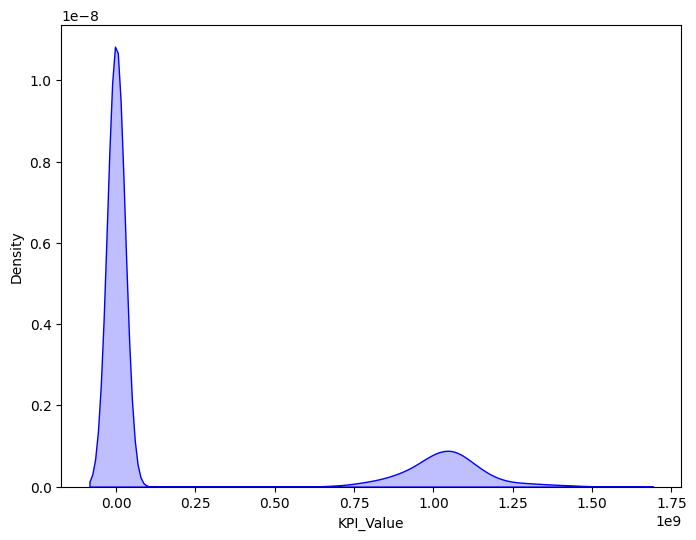

In [9]:
# plot the distribution of KPI values
plt.figure(figsize=(8, 6))
sns.kdeplot(df['KPI_Value'], shade=True, color='b')

In [10]:
# since the standard deviation is very high, we will normalize the KPI values
# using min-max scaling
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler()
df['KPI_Value'] = scaler.fit_transform(df[['KPI_Value']])

In [11]:
# normalizing KPI values
df['KPI_Value'].describe()

count    1.075531e+06
mean     1.545896e-01
std      2.782034e-01
min      0.000000e+00
25%      4.030032e-09
50%      6.337633e-09
75%      8.467318e-07
max      1.000000e+00
Name: KPI_Value, dtype: float64

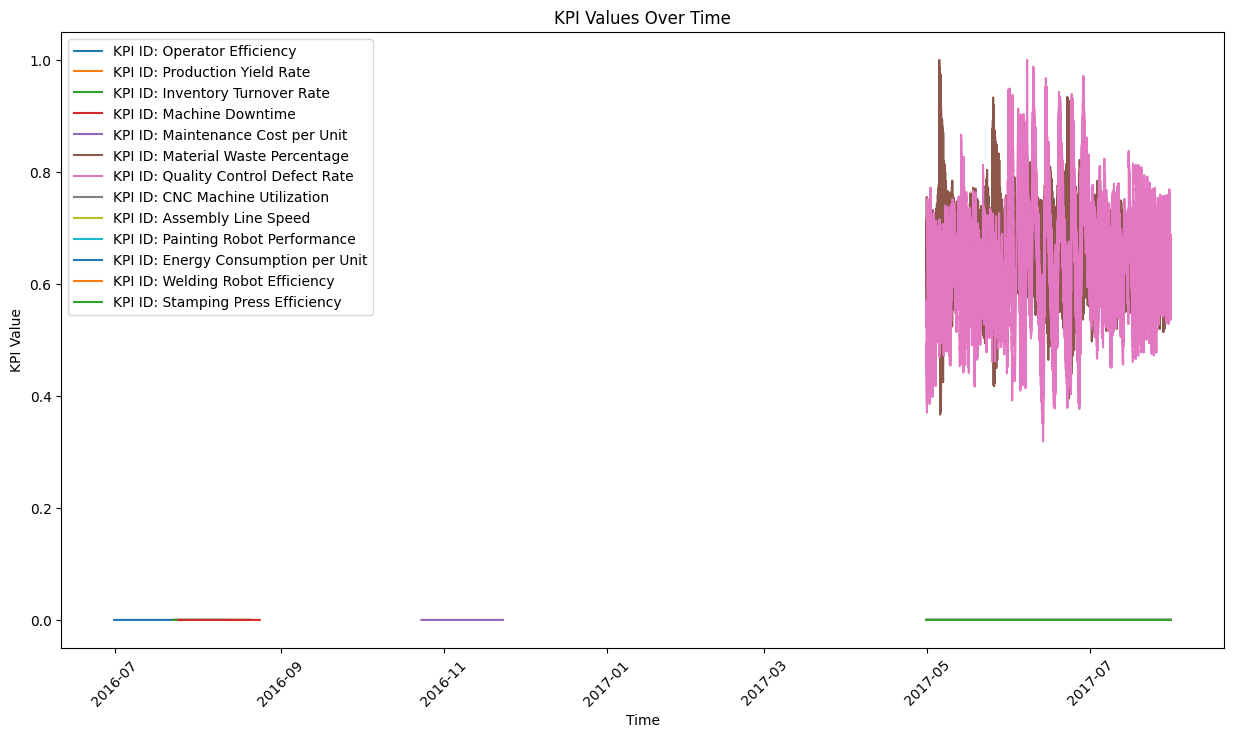

In [12]:
# Plot scaled KPI values over time for each KPI ID
unique_kpis = df['KPI_Name'].unique()

plt.figure(figsize=(15, 8))

for kpi in unique_kpis:
    plt.plot(df[df['KPI_Name'] == kpi]['Timestamp'], df[df['KPI_Name'] == kpi]['KPI_Value'], label=f'KPI ID: {kpi}')

plt.xlabel('Time')
plt.ylabel('KPI Value')
plt.title('KPI Values Over Time')
plt.legend(loc='best')
plt.xticks(rotation=45)
plt.show()

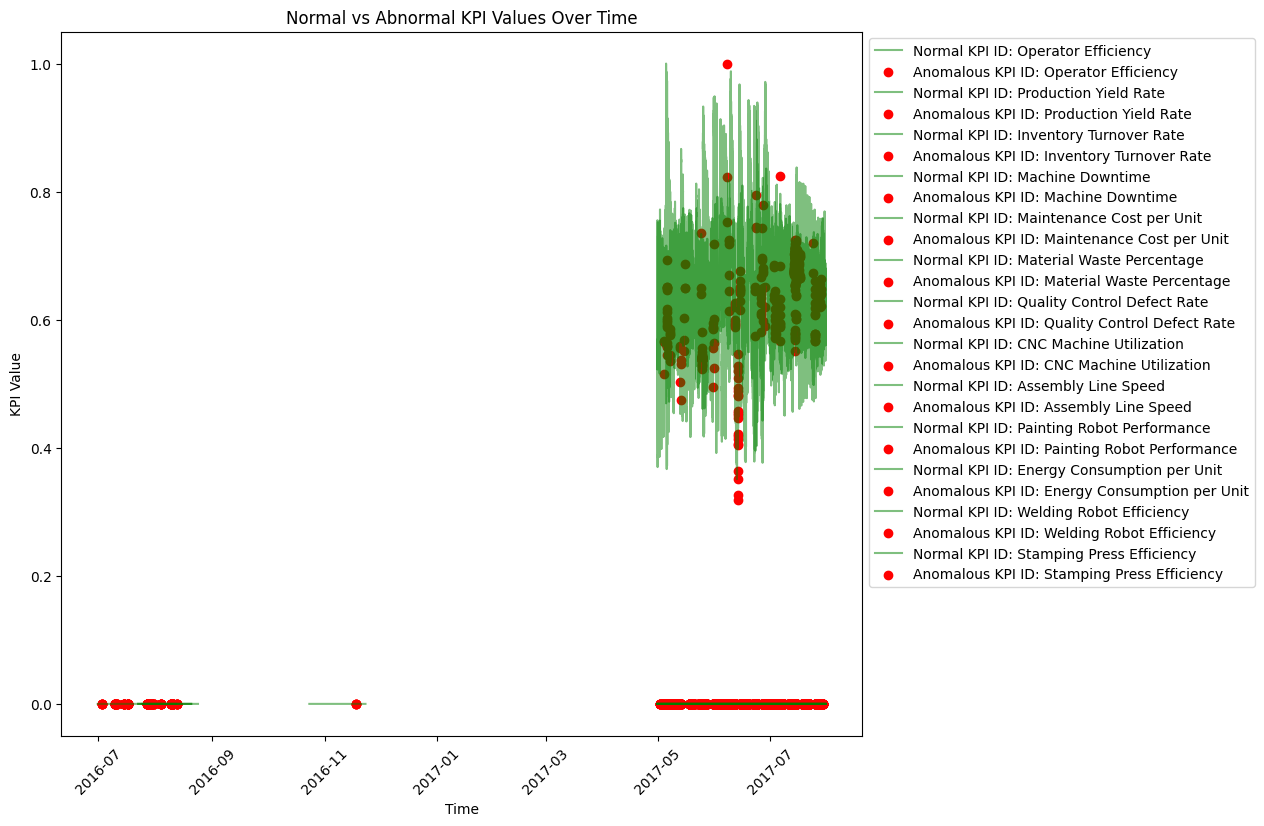

In [13]:
# Separate normal and abnormal data points
normal_data = df[df['Status'] == 0]
abnormal_data = df[df['Status'] == 1]

# Plot normal and abnormal points
plt.figure(figsize=(15, 8))


for kpi in unique_kpis:
    plt.plot(normal_data[normal_data['KPI_Name'] == kpi]['Timestamp'], 
             normal_data[normal_data['KPI_Name'] == kpi]['KPI_Value'], 
             label=f'Normal KPI ID: {kpi}', color='green', alpha=0.5)
    
    plt.scatter(abnormal_data[abnormal_data['KPI_Name'] == kpi]['Timestamp'], 
                abnormal_data[abnormal_data['KPI_Name'] == kpi]['KPI_Value'], 
                label=f'Anomalous KPI ID: {kpi}', color='red')
    
plt.xlabel('Time')
plt.ylabel('KPI Value')
plt.title('Normal vs Abnormal KPI Values Over Time')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.xticks(rotation=45)
plt.show()


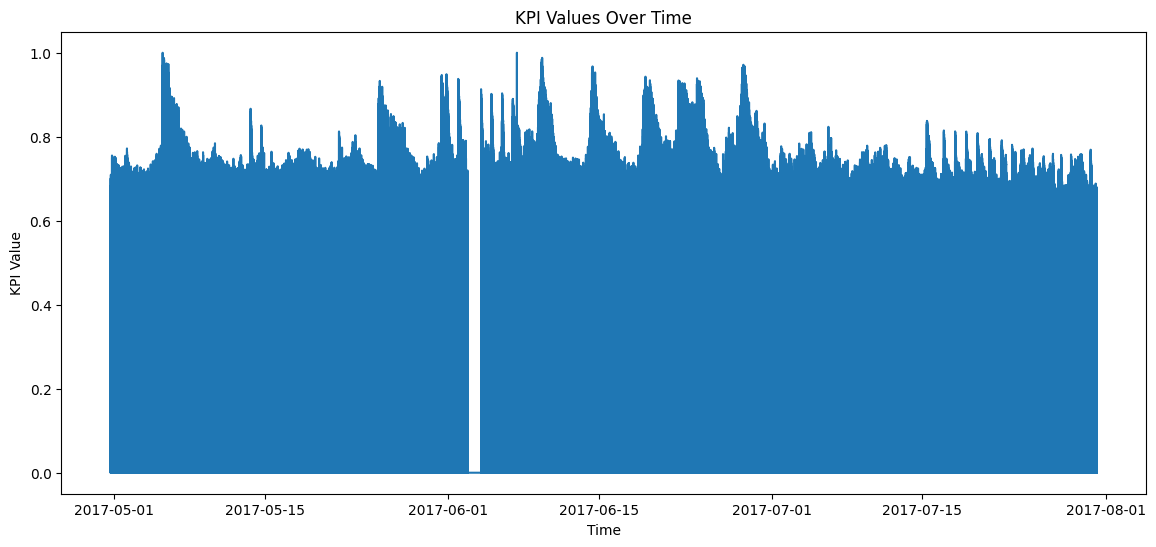

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(df[df['Timestamp'] >= '2017-04-01']['KPI_Value'])
plt.title('KPI Values Over Time')
plt.xlabel('Time')
plt.ylabel('KPI Value')
plt.show()

In [15]:
# handling outliers
from scipy.stats import zscore
df['zscore'] = zscore(df['KPI_Value'])

outliers_z = df[df['zscore'].abs() > 3]
outliers_z

,Timestamp,KPI_Value,Status,KPI_Name,zscore
Timestamp,,,,,
2017-05-05 11:53:00,2017-05-05 11:53:00,0.994407,0,Material Waste Percentage,3.018718
2017-05-05 11:54:00,2017-05-05 11:54:00,0.999913,0,Material Waste Percentage,3.038511
2017-05-05 11:55:00,2017-05-05 11:55:00,0.992162,0,Material Waste Percentage,3.010649
2017-05-05 11:56:00,2017-05-05 11:56:00,0.992845,0,Material Waste Percentage,3.013104
2017-05-05 11:58:00,2017-05-05 11:58:00,0.991240,0,Material Waste Percentage,3.007335
2017-06-07 08:51:00,2017-06-07 08:51:00,1.000000,1,Quality Control Defect Rate,3.038822


In [16]:
Q1 = df['KPI_Value'].quantile(0.25)
Q3 = df['KPI_Value'].quantile(0.75)
IQR = Q3 - Q1

# Identify outliers
outliers_iqr = df[(df['KPI_Value'] < (Q1 - 1.5 * IQR)) | (df['KPI_Value'] > (Q3 + 1.5 * IQR))]
print(f'Outliers identified using IQR:\n{outliers_iqr}')


Outliers identified using IQR:
                              Timestamp  KPI_Value  Status  \
Timestamp                                                    
2017-04-30 16:00:00 2017-04-30 16:00:00   0.663439       0   
2017-04-30 16:00:00 2017-04-30 16:00:00   0.567731       0   
2017-04-30 16:01:00 2017-04-30 16:01:00   0.560616       0   
2017-04-30 16:01:00 2017-04-30 16:01:00   0.656394       0   
2017-04-30 16:02:00 2017-04-30 16:02:00   0.656318       0   
...                                 ...        ...     ...   
2017-07-31 04:25:00 2017-07-31 04:25:00   0.631171       0   
2017-07-31 04:26:00 2017-07-31 04:26:00   0.609187       0   
2017-07-31 04:27:00 2017-07-31 04:27:00   0.624454       0   
2017-07-31 04:28:00 2017-07-31 04:28:00   0.679377       0   
2017-07-31 04:29:00 2017-07-31 04:29:00   0.676101       0   

                                        KPI_Name    zscore  
Timestamp                                                   
2017-04-30 16:00:00    Material Waste Pe

In [17]:
df = df[~df.index.isin(outliers_iqr.index)]


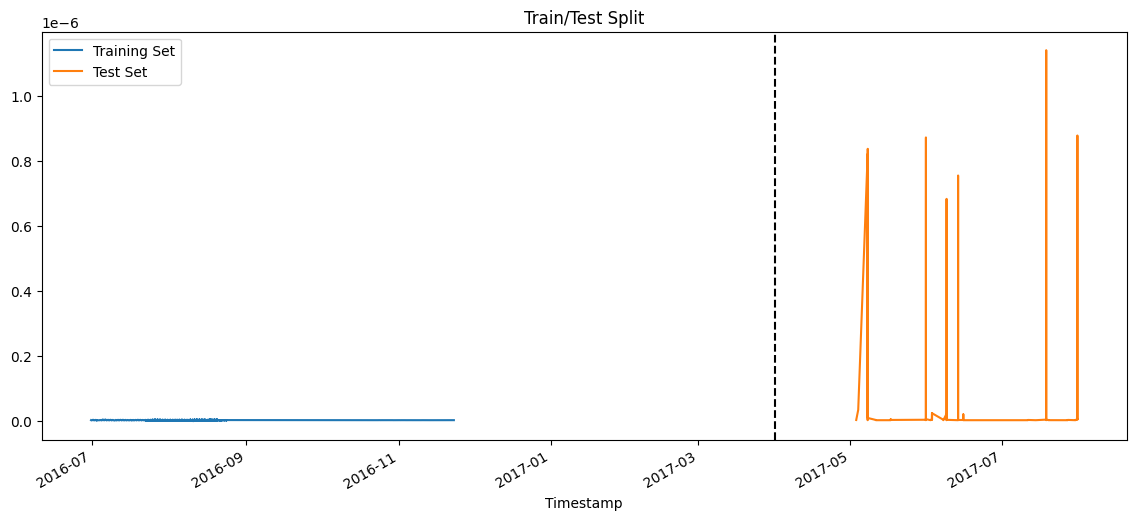

In [18]:
train = df[df['Timestamp'] < '2017-04-01']
test = df[df['Timestamp'] >= '2017-04-01']
fig, ax = plt.subplots(figsize=(14, 6))
train['KPI_Value'].plot(ax=ax, label='Training Set')
test['KPI_Value'].plot(ax=ax, label='Test Set')
ax.axvline('2017-04-01', color='black', linestyle='--')
ax.legend(['Training Set', 'Test Set'])
plt.title('Train/Test Split')
plt.show()

# Feature Engineering and Preparation for Time Series Modeling

In [19]:
tss = TimeSeriesSplit(n_splits=5)
df = df.sort_index()

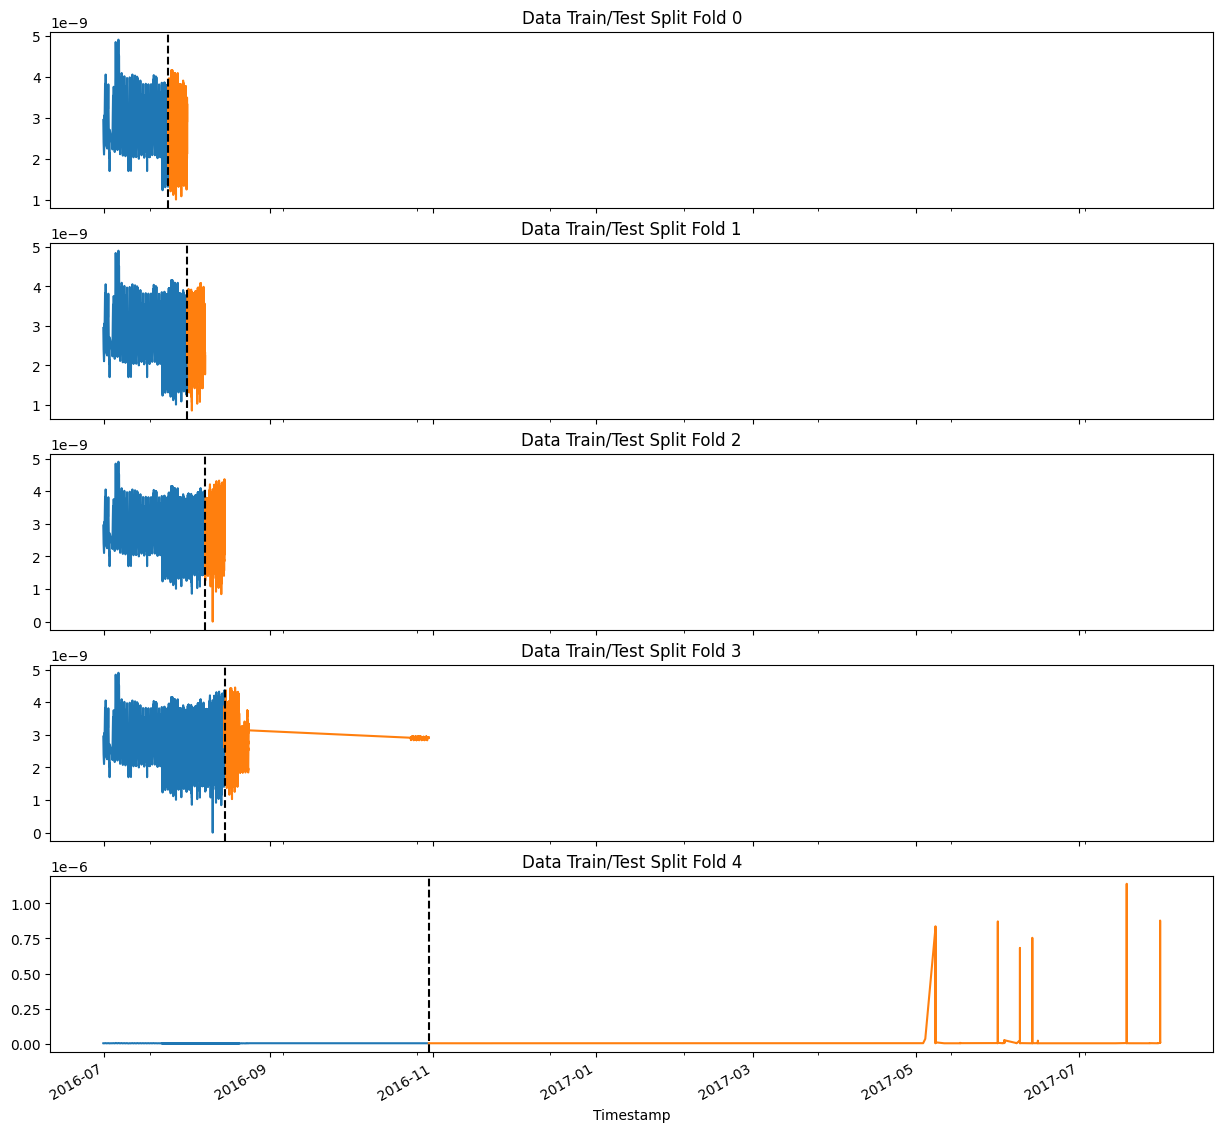

In [20]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['KPI_Value'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['KPI_Value'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [21]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [22]:
# Create lag features
def create_lag_features(df, lags):
    for lag in range(1, lags + 1):
        df[f'lag_{lag}'] = df['KPI_Value'].shift(lag)
    return df

# Create lag features up to lag 5
df = create_lag_features(df, 3)

# Drop rows with NaN values created by lagging
df.dropna(inplace=True)
print(df.shape)

(45840, 16)


In [23]:
fold=0
preds = []
scores = []

In [24]:
for train_index, test_index in tss.split(df):
    train = df.iloc[train_index]
    test = df.iloc[test_index]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag_1','lag_2','lag_3']
    TARGET = 'KPI_Value'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                            n_estimators=1000,
                            early_stopping_rounds=50,
                            objective='reg:linear',
                            max_depth=3,
                            learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:0.49500	validation_1-rmse:0.49500


c:\Users\E15\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:03:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:0.18121	validation_1-rmse:0.18121
[200]	validation_0-rmse:0.06634	validation_1-rmse:0.06634
[300]	validation_0-rmse:0.02428	validation_1-rmse:0.02428
[400]	validation_0-rmse:0.00889	validation_1-rmse:0.00889
[500]	validation_0-rmse:0.00325	validation_1-rmse:0.00325
[600]	validation_0-rmse:0.00119	validation_1-rmse:0.00119
[700]	validation_0-rmse:0.00044	validation_1-rmse:0.00044
[800]	validation_0-rmse:0.00016	validation_1-rmse:0.00016
[900]	validation_0-rmse:0.00006	validation_1-rmse:0.00006
[999]	validation_0-rmse:0.00002	validation_1-rmse:0.00002
[0]	validation_0-rmse:0.49500	validation_1-rmse:0.49500


c:\Users\E15\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:04:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:0.18120	validation_1-rmse:0.18120
[200]	validation_0-rmse:0.06633	validation_1-rmse:0.06633
[300]	validation_0-rmse:0.02428	validation_1-rmse:0.02428
[400]	validation_0-rmse:0.00889	validation_1-rmse:0.00889
[500]	validation_0-rmse:0.00325	validation_1-rmse:0.00325
[600]	validation_0-rmse:0.00119	validation_1-rmse:0.00119
[700]	validation_0-rmse:0.00044	validation_1-rmse:0.00044
[800]	validation_0-rmse:0.00016	validation_1-rmse:0.00016
[900]	validation_0-rmse:0.00006	validation_1-rmse:0.00006
[999]	validation_0-rmse:0.00002	validation_1-rmse:0.00002
[0]	validation_0-rmse:0.49500	validation_1-rmse:0.49500


c:\Users\E15\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:04:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:0.18119	validation_1-rmse:0.18119
[200]	validation_0-rmse:0.06633	validation_1-rmse:0.06633
[300]	validation_0-rmse:0.02428	validation_1-rmse:0.02428
[400]	validation_0-rmse:0.00889	validation_1-rmse:0.00889
[500]	validation_0-rmse:0.00325	validation_1-rmse:0.00325
[600]	validation_0-rmse:0.00119	validation_1-rmse:0.00119
[700]	validation_0-rmse:0.00044	validation_1-rmse:0.00044
[800]	validation_0-rmse:0.00016	validation_1-rmse:0.00016
[900]	validation_0-rmse:0.00006	validation_1-rmse:0.00006
[999]	validation_0-rmse:0.00002	validation_1-rmse:0.00002
[0]	validation_0-rmse:0.49500	validation_1-rmse:0.49500


c:\Users\E15\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:04:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:0.18119	validation_1-rmse:0.18119
[200]	validation_0-rmse:0.06632	validation_1-rmse:0.06632
[300]	validation_0-rmse:0.02428	validation_1-rmse:0.02428
[400]	validation_0-rmse:0.00889	validation_1-rmse:0.00889
[500]	validation_0-rmse:0.00325	validation_1-rmse:0.00325
[600]	validation_0-rmse:0.00119	validation_1-rmse:0.00119
[700]	validation_0-rmse:0.00044	validation_1-rmse:0.00044
[800]	validation_0-rmse:0.00016	validation_1-rmse:0.00016
[900]	validation_0-rmse:0.00006	validation_1-rmse:0.00006
[999]	validation_0-rmse:0.00002	validation_1-rmse:0.00002
[0]	validation_0-rmse:0.49500	validation_1-rmse:0.49500


c:\Users\E15\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:04:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:0.18119	validation_1-rmse:0.18119
[200]	validation_0-rmse:0.06632	validation_1-rmse:0.06632
[300]	validation_0-rmse:0.02428	validation_1-rmse:0.02428
[400]	validation_0-rmse:0.00889	validation_1-rmse:0.00889
[500]	validation_0-rmse:0.00325	validation_1-rmse:0.00325
[600]	validation_0-rmse:0.00119	validation_1-rmse:0.00119
[700]	validation_0-rmse:0.00044	validation_1-rmse:0.00044
[800]	validation_0-rmse:0.00016	validation_1-rmse:0.00016
[900]	validation_0-rmse:0.00006	validation_1-rmse:0.00006
[999]	validation_0-rmse:0.00002	validation_1-rmse:0.00002


In [25]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 0.0000
Fold scores:[2.1614333739810873e-05, 2.159992207207434e-05, 2.1595107135221097e-05, 2.1592696084725148e-05, 2.157640538738154e-05]


In [26]:
# Retrain on all data
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag_1','lag_2','lag_3']
TARGET = 'KPI_Value'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:0.49500


c:\Users\E15\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:04:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:0.18119
[200]	validation_0-rmse:0.06632
[300]	validation_0-rmse:0.02428
[400]	validation_0-rmse:0.00889
[499]	validation_0-rmse:0.00329


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

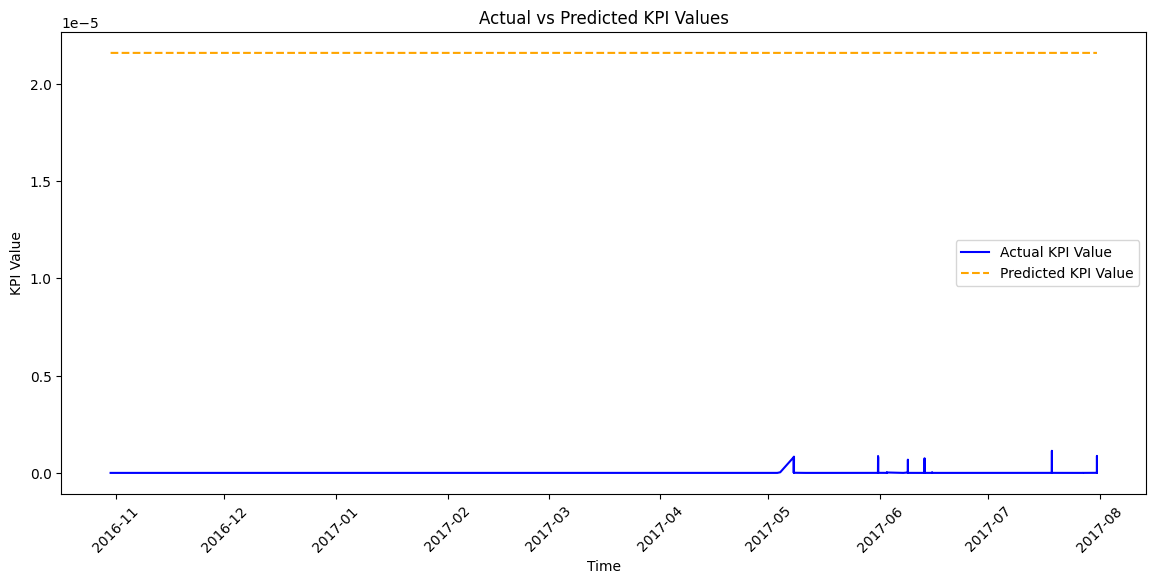

In [27]:
# Plot actual KPI values and predicted values
plt.figure(figsize=(14, 6))

# Plot actual values from the test set
plt.plot(test.index, y_test, label='Actual KPI Value', color='blue', linewidth=1.5)

# Plot predicted values from the test set
plt.plot(test.index, y_pred, label='Predicted KPI Value', color='orange', linestyle='--', linewidth=1.5)

plt.xlabel('Time')
plt.ylabel('KPI Value')
plt.title('Actual vs Predicted KPI Values')
plt.legend()
plt.xticks(rotation=45)
plt.show()


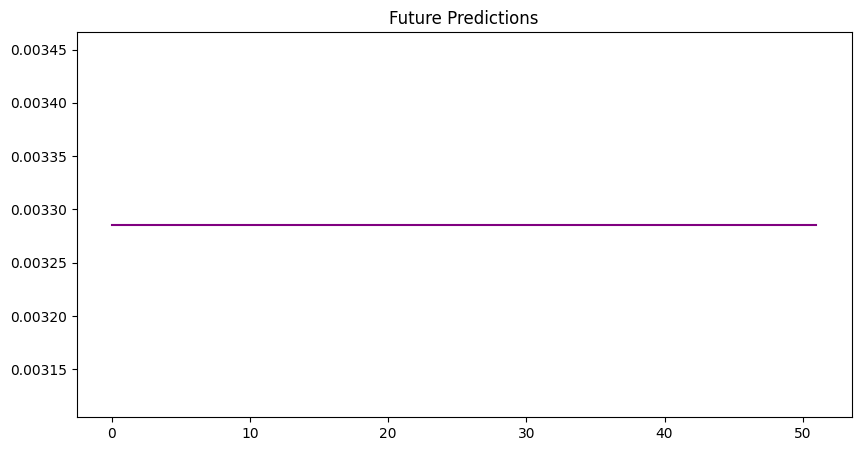

In [28]:
future = pd.date_range('2018-08-03', '2019-08-01', freq='W')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = create_lag_features(df_and_future, 3)

future_preds = reg.predict(df_and_future.query('isFuture')[FEATURES])
plt.figure(figsize=(10, 5))
plt.plot(future_preds, color='purple')
plt.title('Future Predictions')
plt.show()

In [29]:
# save model as json file
reg.save_model('predict_KPI_model.json')
